In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
# import pickle
# import json
path = Path(os.getcwd())
sys.path.append(str(path.parent.absolute()))
# from common_utils import *
from factual_recall_qa.utils import *

DATA_PATH = 'dataset'
DOMAIN=NOBEL_LAUREATES

In [5]:
MATCH_COLUMN = 'attribute_match'
CLOSEST_COLUMN = 'attribute_closest'
DIST_COLUMN = 'closest_dist'
OTHER = 'other'

def make_graphs (concept_class, domain=DOMAIN, bin_count = 20):
    def get_path(concept_class):
        return os.path.join(DATA_PATH, f'icl_query_response_{domain}_{concept_class}.csv')
    def get_match (row):
        for col in metadata[DOMAIN][TARGET_ATTRIBUTES][concept_class]:
            if score_attribute(concept_class, row[GPT_4_RESPONSE], row[col]):
                return col
        return OTHER
    def get_closest (row):
        targ = row[GPT_4_RESPONSE]
        closest_attr = OTHER
        closest_dist = None
        if targ is None or (isinstance(targ, float) and np.isnan(targ)):
            return closest_attr, closest_dist
        for col in metadata[DOMAIN][TARGET_ATTRIBUTES][concept_class]:
            gen = row[col]
            if gen is None or (isinstance(gen, float) and np.isnan(gen)):
                return closest_attr, closest_dist
            if concept_class == ConceptClass.YEAR.value:
                dist = float(extract_year(targ)) - float(extract_year(gen))
            else:
                dist = name_similarity_exact(str(targ), str(gen))
            if closest_dist is None or abs(dist) < abs(closest_dist):
                closest_attr = col
                closest_dist = dist
        return closest_attr, closest_dist

    df = pd.read_csv(get_path(concept_class),dtype=str)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns='Unnamed: 0')
    df[MATCH_COLUMN] = df.apply(get_match, axis=1)
    df[CLOSEST_COLUMN], df[DIST_COLUMN] = zip(*df.apply(get_closest, axis=1))
    # display(df.head())

    # bargraph of all responses
    piv_all = df.pivot_table(index=TARGET_ATTRIBUTES,columns=MATCH_COLUMN, values=GROUND_TRUTH, aggfunc='count', fill_value=0)
    piv_all = piv_all[[col for col in piv_all.columns if col != OTHER]+[OTHER]] # reorder columns (for legend)
    piv_all = piv_all.div(piv_all.sum(axis=1), axis=0)*100 # normalize rows and convert to percents
    # display(piv_all)
    piv_all.plot(kind='bar', stacked=True, ylabel='proportion of responses (%)', title=f'GPT-4 responses: {domain} "{concept_class}" attributes')
    plt.show()

    # histogram of all closest distance
    min_dist = (min([d for d in df[DIST_COLUMN] if d is not None]))
    max_dist = (max([d for d in df[DIST_COLUMN] if d is not None]))
    bins = list(np.arange(min_dist, max_dist, (max_dist-min_dist)/bin_count))
    for group_name, group_data in df.groupby(CLOSEST_COLUMN)[DIST_COLUMN]:
        # if bins is None:
        #     counts, bins = np.histogram(group_data)
        plt.hist(group_data, label=group_name, alpha=0.5, bins=bins)
    plt.xlabel("distance from closest value")
    plt.ylabel('# of responses')
    plt.title(f'GPT-4 responses: {domain} "{concept_class}" attributes')
    plt.legend(title='closest attribute')
    plt.show()

    # bargraph of just hallucinations
    hall = df[df[MATCH_COLUMN] == OTHER]
    piv_hall = hall.pivot_table(index=TARGET_ATTRIBUTES,columns=CLOSEST_COLUMN, values=GROUND_TRUTH, aggfunc='count', fill_value=0)
    piv_hall = piv_hall[[col for col in piv_hall.columns if col != OTHER]+[col for col in piv_hall.columns if col == OTHER]] # reorder columns (for legend)
    # piv_hall = piv_hall.div(piv_hall.sum(axis=1), axis=0)*100 # normalize rows and convert to percents
    # display(piv_hall)
    piv_hall.plot(kind='bar', stacked=True, ylabel='number of incorrect responses (%)', title=f'GPT-4 hallucinations: {domain} "{concept_class}" attributes')
    plt.show()

    # histogram of hallucination closest distance
    min_dist = (min([d for d in hall[DIST_COLUMN] if d is not None]))
    max_dist = (max([d for d in hall[DIST_COLUMN] if d is not None]))
    bins = list(np.arange(min_dist, max_dist, (max_dist-min_dist)/bin_count))
    for group_name, group_data in hall.groupby(CLOSEST_COLUMN)[DIST_COLUMN]:
        # if bins is None:
        #     counts, bins = np.histogram(group_data)
        plt.hist(group_data, label=group_name, alpha=0.5, bins=bins)
    plt.xlabel("distance from closest value")
    plt.ylabel('# of hallucinations')
    plt.title(f'GPT-4 hallucinations: {domain} "{concept_class}" attributes')
    plt.legend(title='closest attribute')
    plt.show()
    
    return df

,icl_prompt,ground_truth,target_attributes,GPT 4 Response,born,died,year,attribute_match,attribute_closest,closest_dist
0,"Akira, Suzuki, ""for palladium-catalyzed cross ...",1917,born,1917,1917,1985,1972,born,born,0.0
1,"Vitaly L., Ginzburg, ""for pioneering contribut...",1913,born,1913,1913,2005,1985,born,born,0.0
2,"Werner, Forssmann, ""for their discoveries conc...",1946,born,1946,1946,2016,1999,born,born,0.0
3,"Vicente, Aleixandre, ""for a creative poetic wr...",1920,born,1920,1920,2017,1981,born,born,0.0
4,"Vincent, du Vigneaud, ""for his work on biochem...",1905,born,1905,1905,1984,1965,born,born,0.0


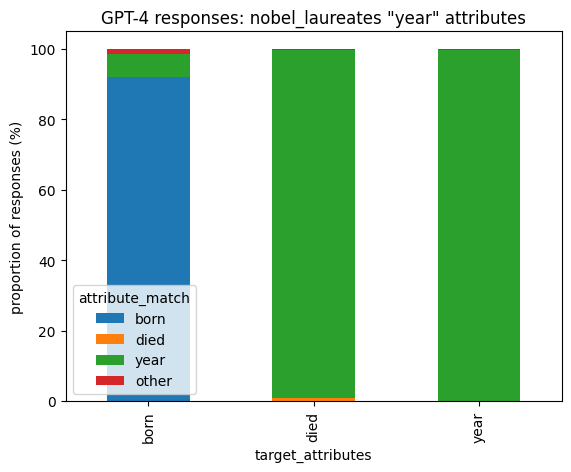

c:\Users\eviye\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\eviye\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


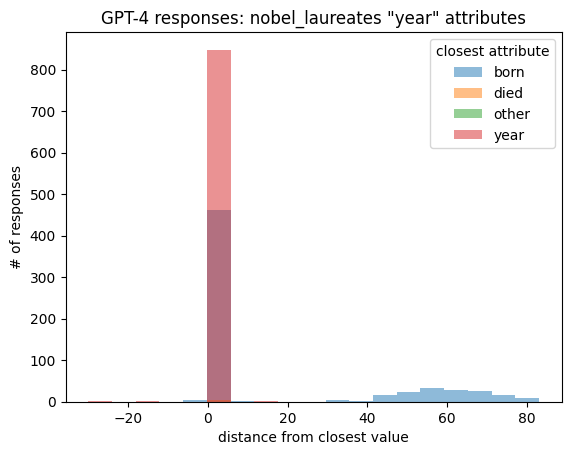

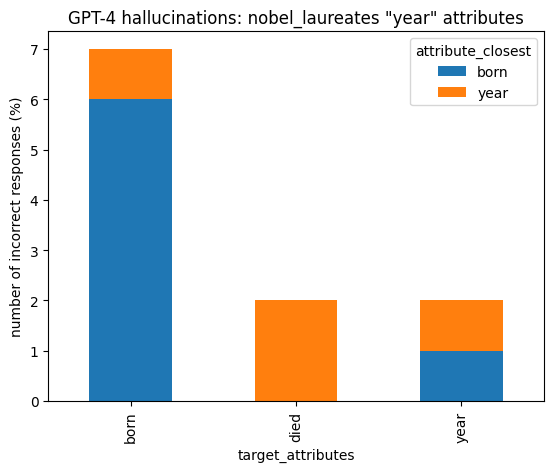

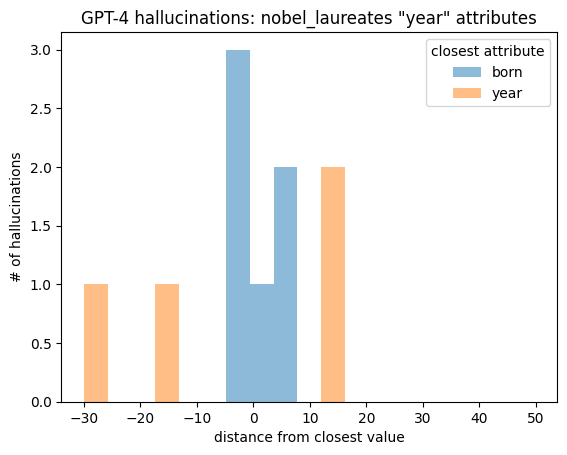

In [6]:
# graphs for nobel year
year = make_graphs(ConceptClass.YEAR.value)

,icl_prompt,ground_truth,target_attributes,GPT 4 Response,borncity,diedcity,city,attribute_match,attribute_closest,closest_dist
0,"George F., Smoot, ""for their discovery of the ...",Elizabeth NJ,borncity,"Elizabeth, New Jersey",Elizabeth NJ,New York NY,New York NY,borncity,borncity,1.000000
1,"Derek, Barton, ""for their contributions to the...",Dili,borncity,Dili,Dili,NaN,NaN,borncity,borncity,1.000000
2,"Robert H., Grubbs, ""for the development of the...",Dieppe,borncity,"Dieppe, France",Dieppe,Paris,Paris,borncity,diedcity,0.153846
3,"Boris, Pasternak, ""for his important achieveme...",Rotterdam,borncity,Berlin,Rotterdam,Berlin,Berlin,diedcity,borncity,0.222222
4,"Romain, Rolland, ""as a tribute to the lofty id...",Schroda,borncity,Munich,Schroda,NaN,Stuttgart,other,borncity,0.000000


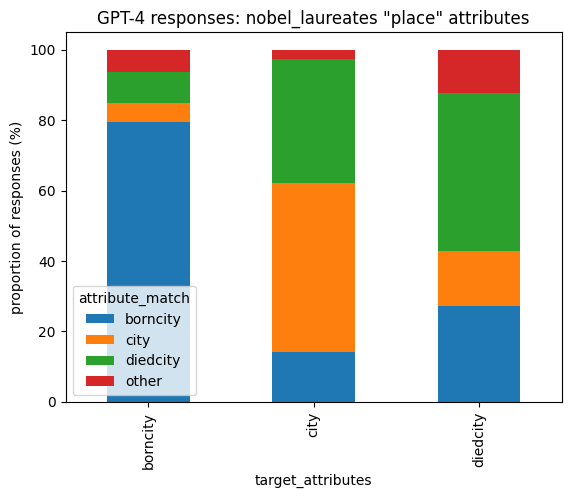

c:\Users\eviye\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\eviye\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


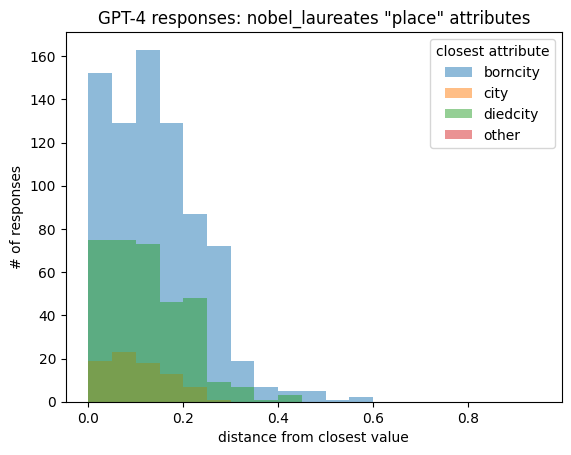

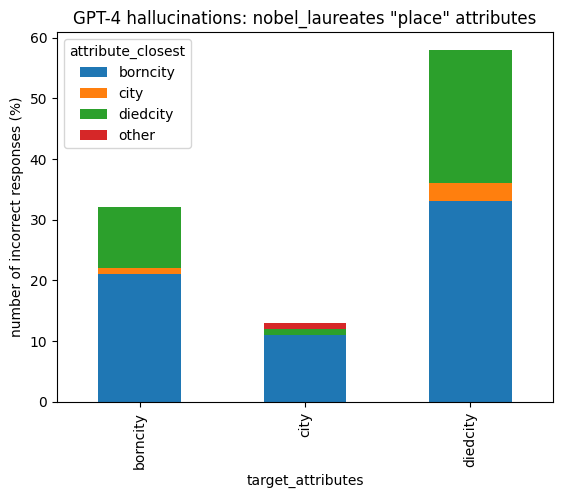

c:\Users\eviye\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\eviye\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


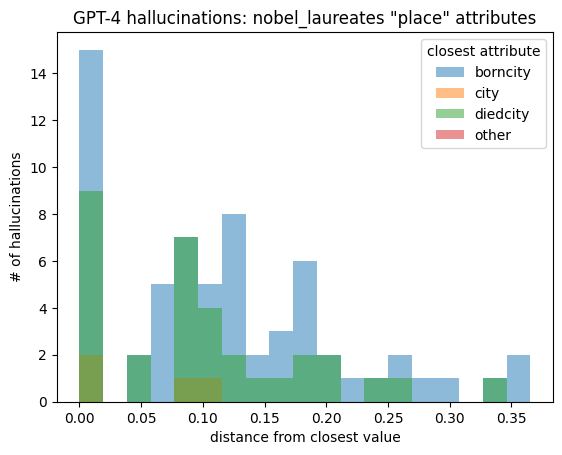

In [7]:
# graphs for nobel place
place = make_graphs(ConceptClass.PLACE.value)